# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [6]:
import pymorphy2
from string import punctuation

In [7]:
def lemmatization(data):
    data = data.copy()
    pymorph = pymorphy2.MorphAnalyzer()
    for index in data.index:
        result = ''
        text_prepare = ''.join(c for c in data[index].lower() if c not in  punctuation).split(u' ')
        for word in text_prepare:
            if not re.match('u([^0-9a-zа-я]+)', word):
                word = pymorph.parse(word)[0].normal_form
                result = result + ' ' + word
        data[index] = result
    return data

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                        batch_size=100)

DiskReadException: File school.txt does not exist.

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [49]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [46]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [50]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [51]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [40]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

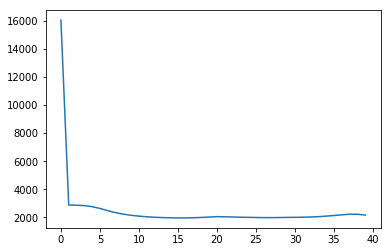

In [41]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [11]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=' ')
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=' ')
    print()

sbj0:  который быть что это человек этот как свой для они его весь такой время себя 
sbj1:  a множитель возведение b скобка x раскладывать умножение сокращенный разложение ответ квадрат слагаемое многочлен выражение 
sbj2:  обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго 
sbj3:  который быть год свой время государство человек мир становиться жизнь северный первый война африка ребенок 
sbj4:  x a b уравнение дробь квадратный y степень функция число f решение корень c пример 
sbj5:  быть год пушкин функция свой его русский который поэт империя культура весь a f трение 
sbj6:  сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина 
sbj7:  который что это как человек для этот такой быть являться мочь себя она его свой 
sbj8:  который быть что это свой как этот человек для x они такой государство a весь 
sbj9:  который быть что этот это как человек свой дл

Давайте посмотрим также на разреженность матриц:

In [12]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333126068115234
0.16533613204956055


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [52]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [53]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

### Куда пропадают темы??

In [54]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=' ')
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=' ')
    print()

sbj0:  быть что это который этот как человек для свой они весь такой время его себя 
sbj1:  который быть весь также один жизнь свой b год становиться произведение что его герой этот 
sbj2:  который предложение слово свой его жизнь сила что пушкин главный человек она творчество произведение поэт 
sbj3:  что как человек это быть этот свой страна для они такой ядро государство так сила 
sbj4:  x a уравнение если y напряжение c при квадрат формула тело функция звук сопротивление число 
sbj5:  быть который год весь что этот это функция для как человек становиться время пушкин мочь 
sbj6:  быть который что как это свой этот год человек такой они весь один себя мочь 
sbj7:  человек который герой что его произведение для тот литература русский b отношение социальный свой являться 
sbj8:  быть который это как этот свой государство они для что такой год весь являться страна 
sbj9:  который ток магнитный при число поле быть n для энергия этот электрический следующий поверхность если 


In [55]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7037952542304993
0.0004201680712867528


Попробуем менять коэффициент регуляризации:

In [56]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [57]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [58]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=' ')
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=' ')
    print()

sbj0:  вода корень древний квадратный океан собственный крестьянин зона достигать нет течение среди прямой предприятие луч 
sbj1:  b власть свобода эпоха исторический жанр церковь бог правовой защита гражданский падение философский изображать топливо 
sbj2:  слово предложение пушкин поэт стихотворение простой писатель творчество любовь роман маленький лирика глагол написать имя 
sbj3:  иметь сила страна называть большой основной процесс находиться система наш высокий количество место ядро здесь 
sbj4:  x a уравнение дробь звук свет формула y напряжение промежуток c ноль записывать сопротивление преломление 
sbj5:  функция f империя входить ссср скорость определение область физика жидкость реформа восстание газ знак революция 
sbj6:  африка сфера качество географический ресурс лермонтов ядерный среда гражданин сказка цивилизация международный поведение окружать впервые 
sbj7:  герой произведение отношение социальный друг литература автор литературный поэтому личность рассказ чувство выр

In [59]:
# еще раз посмотрим на разреженность
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9045282602310181
0.1521008461713791


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [60]:
model_artm.save("my_model")

In [61]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [62]:
phi = model_artm.get_phi()

In [63]:
phi

sbj0      sbj1      sbj2      sbj3  \
домохозяйка                       0.000000  0.000126  0.000000  0.000000   
институт                          0.000000  0.000000  0.000000  0.000000   
машинка                           0.000000  0.000000  0.000000  0.000000   
прочий                            0.000000  0.000000  0.000000  0.000000   
навязнуть                         0.000000  0.000000  0.000000  0.000000   
физиология                        0.000000  0.000000  0.000000  0.000000   
истязать                          0.000000  0.000000  0.000000  0.000000   
выборы                            0.000000  0.000000  0.000000  0.000000   
кндр                              0.000000  0.000000  0.000000  0.000194   
федерализм                        0.000000  0.000000  0.000000  0.000000   
отсчитываться                     0.000000  0.000000  0.000000  0.000000   
распространяться                  0.000000  0.000000  0.000000  0.000000   
прикасаться                       0.000000  0.000000  0.000000  0.000000   
батырь                            0.000089  0.000000  0.000000  0.000000   
обществеОгромное                  0.000000  0.000000  0.000000  0.000000   
бить                              0.000000  0.000000  0.000000  0.000000   
отдалять                          0.000178  0.000000  0.000000  0.000000   
речка                             0.000000  0.000000  0.000000  0.000000   
неполноценность                   0.000000  0.000000  0.000000  0.000000   
невозможенУже                     0.000000  0.000000  0.000000  0.000000   
развивающийся                     0.000000  0.000000  0.000000  0.000517   
теплопроводностиТеплопроводность  0.000000  0.000000  0.000000  0.000000   
заповедник                        0.000000  0.000000  0.000000  0.000000   
преувеличиваться                  0.000000  0.000000  0.000000  0.000000   
межнациональный                   0.000000  0.000000  0.000000  0.000000   
протест                           0.000000  0.000000  0.000000  0.000000   
виднеться                         0.000000  0.000000  0.000444  0.000000   
основа                            0.000000  0.000000  0.000000  0.000000   
преграда                          0.000000  0.000000  0.000000  0.000258   
топливо                           0.000000  0.004679  0.000000  0.000000   
...                                    ...       ...       ...       ...   
обывательщина                     0.000000  0.000000  0.000222  0.000000   
настрой                           0.000000  0.000000  0.000222  0.000000   
нелегкий                          0.000000  0.000000  0.000222  0.000000   
рассказеГранатовый                0.000000  0.000000  0.000222  0.000000   
простираться                      0.000000  0.000000  0.000000  0.000065   
Маншского                         0.000000  0.000000  0.000000  0.000065   
колонизаторский                   0.000000  0.000000  0.000000  0.000065   
пикардия                          0.000000  0.000000  0.000000  0.000065   
нормандия                         0.000000  0.000000  0.000000  0.000065   
Пуату                             0.000000  0.000000  0.000000  0.000065   
Шаранта                           0.000000  0.000000  0.000000  0.000065   
овернь                            0.000000  0.000000  0.000000  0.000065   
пиренеи                           0.000000  0.000000  0.000000  0.000129   
прованс                           0.000000  0.000000  0.000000  0.000065   
корсик                            0.000000  0.000000  0.000000  0.000065   
лазурный                          0.000000  0.000000  0.000000  0.000065   
савойя                            0.000000  0.000000  0.000000  0.000065   
монблан                           0.000000  0.000000  0.000000  0.000065   
гарон                             0.000000  0.000000  0.000000  0.000065   
аист                              0.000000  0.000000  0.000000  0.000065   
корсиканский                      0.000000  0.000000  0.000000  0.000065   
серна     

Матрица вероятностей тем в документах.

In [64]:
theta = model_artm.get_theta()
theta

0         1         2         3         4         5         6    \
sbj0  0.065327  0.031088  0.115385  0.061224  0.094340  0.029197  0.011236   
sbj1  0.055276  0.041451  0.023077  0.045918  0.019508  0.029197  0.187266   
sbj2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
sbj3  0.080402  0.119171  0.207692  0.102041  0.132075  0.094891  0.026217   
sbj4  0.005025  0.000000  0.000000  0.005102  0.000000  0.000000  0.689138   
sbj5  0.075377  0.139896  0.030769  0.051020  0.028302  0.021898  0.000000   
sbj6  0.015075  0.025907  0.069231  0.030612  0.018868  0.029197  0.003745   
sbj7  0.015075  0.025907  0.046154  0.025510  0.009434  0.153285  0.078652   
sbj8  0.688442  0.616580  0.507692  0.678572  0.697473  0.642336  0.003745   
sbj9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7         8         9      ...          190       191       192  \
sbj0  0.020000  0.126667  0.035928    ...     0.038217  0.227468  0.088889   
sbj1  0.040000  0.025606  0.011976    ...     0.114650  0.047210  0.040000   
sbj2  0.000000  0.000000  0.000000    ...     0.031847  0.004292  0.000000   
sbj3  0.100000  0.193333  0.059880    ...     0.286624  0.274678  0.160000   
sbj4  0.000000  0.247727  0.473054    ...     0.000000  0.000000  0.000000   
sbj5  0.046667  0.140000  0.335329    ...     0.012739  0.038627  0.031111   
sbj6  0.033333  0.093333  0.000000    ...     0.210191  0.167382  0.462222   
sbj7  0.460000  0.020000  0.011976    ...     0.203822  0.012876  0.062222   
sbj8  0.300000  0.153333  0.071856    ...     0.095541  0.166620  0.137778   
sbj9  0.000000  0.000000  0.000000    ...     0.006369  0.060848  0.017778   

           193       194       195       196       197       198       199  
sbj0  0.125749  0.090396  0.106509  0.067416  0.122066  0.102190  0.035714  
sbj1  0.059880  0.022599  0.124260  0.061798  0.009390  0.051095  0.107143  
sbj2  0.023952  0.011299  0.000000  0.022472  0.000000  0.058394  0.000000  
sbj3  0.125748  0.129944  0.124260  0.089888  0.173709  0.131387  0.125000  
sbj4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
sbj5  0.023952  0.118644  0.030391  0.151685  0.028169  0.000423  0.000000  
sbj6  0.377245  0.231638  0.348307  0.264045  0.370892  0.393737  0.000000  
sbj7  0.035928  0.039548  0.059172  0.044944  0.014085  0.197080  0.428571  
sbj8  0.227545  0.338983  0.207101  0.297753  0.140845  0.065693  0.125000  
sbj9  0.000000  0.016949  0.000000  0.000000  0.140845  0.000000  0.178571  

[10 rows x 476 columns]

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [65]:
theta_test = model_artm.transform(batch_vectorizer)

In [66]:
theta_test

0         1         2         3         4         5         6    \
sbj0  0.065327  0.031088  0.115385  0.061224  0.094340  0.029197  0.011236   
sbj1  0.055276  0.041451  0.023077  0.045918  0.019509  0.029197  0.187266   
sbj2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
sbj3  0.080402  0.119171  0.207692  0.102041  0.132075  0.094891  0.026217   
sbj4  0.005025  0.000000  0.000000  0.005102  0.000000  0.000000  0.689138   
sbj5  0.075377  0.139896  0.030769  0.051020  0.028302  0.021898  0.000000   
sbj6  0.015075  0.025907  0.069231  0.030612  0.018868  0.029197  0.003745   
sbj7  0.015075  0.025907  0.046154  0.025510  0.009434  0.153285  0.078652   
sbj8  0.688442  0.616580  0.507692  0.678572  0.697473  0.642336  0.003745   
sbj9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7         8         9      ...          190       191       192  \
sbj0  0.020000  0.126667  0.035928    ...     0.038217  0.227468  0.088889   
sbj1  0.040000  0.025606  0.011976    ...     0.114650  0.047210  0.040000   
sbj2  0.000000  0.000000  0.000000    ...     0.031847  0.004292  0.000000   
sbj3  0.100000  0.193333  0.059880    ...     0.286624  0.274678  0.160000   
sbj4  0.000000  0.247727  0.473054    ...     0.000000  0.000000  0.000000   
sbj5  0.046667  0.140000  0.335329    ...     0.012739  0.038627  0.031111   
sbj6  0.033333  0.093333  0.000000    ...     0.210191  0.167382  0.462223   
sbj7  0.460000  0.020000  0.011976    ...     0.203822  0.012876  0.062222   
sbj8  0.300000  0.153333  0.071856    ...     0.095541  0.166618  0.137778   
sbj9  0.000000  0.000000  0.000000    ...     0.006369  0.060849  0.017778   

           193       194       195       196       197       198       199  
sbj0  0.125749  0.090396  0.106509  0.067416  0.122066  0.102190  0.035714  
sbj1  0.059880  0.022599  0.124260  0.061798  0.009390  0.051095  0.107143  
sbj2  0.023952  0.011299  0.000000  0.022472  0.000000  0.058394  0.000000  
sbj3  0.125749  0.129944  0.124260  0.089888  0.173709  0.131387  0.125000  
sbj4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
sbj5  0.023952  0.118644  0.030392  0.151685  0.028169  0.000416  0.000000  
sbj6  0.377246  0.231638  0.348306  0.264045  0.370892  0.393745  0.000000  
sbj7  0.035928  0.039548  0.059172  0.044944  0.014085  0.197080  0.428571  
sbj8  0.227545  0.338983  0.207101  0.297753  0.140845  0.065693  0.125000  
sbj9  0.000000  0.016949  0.000000  0.000000  0.140845  0.000000  0.178571  

[10 rows x 476 columns]